In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:100%; }")

In [2]:
from graphviz import Digraph
from collections import deque

# Splay Trees

In diesem Notebook wird eine bestimmte Art von selbstbalancierenden Bäumen gezeigt, die *Splay Trees*. Diese Datenstruktur wurde [1985 von Sleator und Tarjan eingeführt](http://www.cs.cmu.edu/~sleator/papers/self-adjusting.pdf "D. D. Sleator, R. E. Tarjan (1985): Self-Adjusting Binary Search Trees. Journal of the ACM, 32(3) 652-686"). Im Gegensatz zu anderen selbstbalancierenden Bäumen wie *AVL-Bäumen* wird bei Splay Trees nicht gefordert, dass der Baum zu allen Zeiten so gut wie möglich balanciert ist. Stattdessen wird der Baum dahingehend optimiert, dass häufig verwendete Elemente nahe an der Wurzel sind.

Auf Basis dieser Bäume soll später eine alternative Implementierung von Mengen in der Programmiersprache Python entstehen. In der Referenzimplementierung *CPython* sind [Mengen auf Basis von *Hashtabellen* implementiert](https://github.com/python/cpython/blob/3.8/Objects/setobject.c "R. D. Hettinger et al. (2019): cpython/Objects/setobject.c, GitHub"). Viele andere weit verbreitete Implementierungen anderer Programmiersprachen benutzen für Mengen ebenfalls Hashtabellen oder haben dies zumindest als Option, wie in [Java](https://docs.oracle.com/en/java/javase/13/docs/api/java.base/java/util/Set.html "Oracle Corp. (2019): Set (Java SE13 & JDK 13)"), [.NET (C#)](https://docs.microsoft.com/en-us/dotnet/api/system.collections.generic.iset-1?view=netframework-4.8, "Microsoft Corp. (2019): ISet<T> Interface (System.Collections.Generic), Microsoft Docs"), [JavaScript](https://v8.dev/blog/hash-code "Sathya Gunasekaran (2018): Optimizing hash tables: hiding the hash code, V8 Blog") oder [PHP](https://www.php.net/manual/en/class.ds-set.php "The PHP Group (2019): PHP: Set, Manual"). Jedoch macht die Verwendung von Bäumen für Mengen einige mengenlastige Programmierprobleme einfacher zu lösen, da diese Mengen *geordnet* sind und somit beispielsweise ein einfach zu bestimmendes Minimum und ein Maximum haben.

Die reine Datenstruktur – ohne Operationen – ist bei Splay Trees genauso wie bei regulären geordneten binären Bäumen definiert: $\text{Node}(p, l, r)$ ist ein Baum, wobei
- $p$ eine Nutzlast (payload) ist,
- $l$ der linke Teilbaum ist und
- $r$ der rechte Teilbaum ist.

In [3]:
class Node:
    def __init__(self, payload, left, right):
        self.payload = payload
        self.left = left
        self.right = right

Wir verlangen dabei:

- Für alle Nutzlasten aus dem linken Teilbaum $l$ gilt, dass sie kleiner als die Nutzlast $p$ sind.
- Für alle Nutzlasten aus dem rechten Teilbaum $r$ gilt, dass sie größer als die Nutzlast $p$ sind.

Diese Aussagen können auch als $l < p < r$ formuliert werden.

Die Betrachtung des Falls, dass eine Nutzlast in einem Teilbaum $l, r$ gleich der Nutzlast $p$ ist, entfällt, da Mengen keine doppelten Elemente enthalten. Diese Forderung impliziert außerdem, dass die Nutzlasten geordnet werden können. Wir behandeln später, wie wir beliebigen Nutzlasten in Python eine Ordnung geben können.

Wir definieren zunächst die Methode `graph`, die einen Baum auf Basis von dem [Python-Interface](https://github.com/xflr6/graphviz "S. Bank (2019): graphviz, GitHub") zu [*Graphviz*](https://graphviz.org/ "J. Ellson et al. (2019): Graphviz") visualisiert. Dies erleichtert später die Erklärungen anderer Operationen. `graph` benutzt `_graph`, eine Methode, die einem bestehenden Graphen die Knoten hinzufügt. `_graph` nimmt zusätzlich eine Menge von benutzten Schlüsseln für die Knoten und einen Zähler, der Schlüssel für leere Blätter im Baum liefert. `graph` nimmt optional eine Liste von Objekten, die ebenfalls `_graph` unterstützen. Dies können wir benutzen, um eine Transformation im Baum zu zeigen. Zur besseren Illustrierung kann dazwischen ein Objekt der Klasse `Method` benutzt werden, die wir ebenfalls definieren. Wir benötigen ebenfalls zum Illustrieren einen Baum, der nur ein Kind hat, den `UnaryTree`.

In [4]:
def graph(self, additionals = []):
    dot = Digraph()
    used, key = self._graph(dot, set(), 0)
    for el in additionals:
        used, key = el._graph(dot, used, key)
    return dot

def _graph(self, dot, used, key):
    used.add(id(self))
    dot.node(str(id(self)), label=str(self.payload))
    if not (self.left is None and self.right is None):
        for node in self.left, self.right:
            if node is not None:
                dot.edge(str(id(self)), str(id(node)))
                used, key = node._graph(dot, used, key)
            else:
                while True:
                    key += 1
                    if key not in used:
                        break
                used.add(key)
                dot.node(str(key), shape="point")
                dot.edge(str(id(self)), str(key))
    return used, key

Node.graph = graph
Node._graph = _graph
del graph
del _graph

class Method:
    def __init__(self, name):
        self.name = name
    
    def _graph(self, dot, used, key):
        used.add(id(self))
        dot.node(str(id(self)), label=str(self.name) + " ⇒", shape="rectangle", style="dotted")
        return used, key

class UnaryTree:
    def __init__(self, name, child):
        self.name = name
        self.child = child
    
    def graph(self, additionals = []):
        dot = Digraph()
        used, key = self._graph(dot, set(), 0)
        for el in additionals:
            used, key = el._graph(dot, used, key)
        return dot
    
    def _graph(self, dot, used, key):
        used.add(id(self))
        dot.node(str(id(self)), label=str(self.name), shape="triangle")
        if not self.child is None:
            dot.edge(str(id(self)), str(id(self.child)))
            used, key = self.child._graph(dot, used, key)
        return used, key

## Splaying

Die Besonderheit von Splay Trees ist, dass mit allen Baumoperationen, die ein Element im Baum lokalisieren, eine besondere Operation, der *Splay*, durchgeführt wird. Mit Baumoperationen, die ein Element im Baum lokalisieren, sind alle Operationen auf den Baum gemeint, die den Baum auf der Suche nach einem Element oder auf der Suche nach dem richtigen Ort für ein Element durchsuchen. Dazu gehören das Einfügen, Löschen und Finden von Elementen.

Der Splay ist eine Funktion, die einen Baum dahingehend modifiziert, dass ein Knoten, der schon im Baum enthalten ist, die neue Wurzel des Baums wird:

$$\text{splay}: \text{Node} \times \text{Node} \to \text{Node}$$

Ist der angegebene Knoten im Baum, so ist gerade dieser die neue Wurzel.

Wir arbeiten mit dem *Top-Down*-Ansatz, bei dem wir von der Wurzel aus so lange Knoten beiseite legen, bis der zu splayende Knoten die Wurzel darstellt, und diese beiseite gelegten Knoten wieder unterordnen. Dieser Ansatz wurde in der ursprünglichen Veröffentlichung bereits beschrieben (S. 667ff.), aber erst [1987 von Mäkinen als in Komplexität etwas begrenzter analysiert](https://link.springer.com/article/10.1007%2FBF01933728 "E. Mäkinen (1987): On top-down splaying. BIT Numerical Mathematics, 27 330-339 (SpringerLink)").

Beim Top-Down-Splaying werden die drei Bäume $L, M, R$ (links, mitte, rechts) betrachtet. Der Baum, der bearbeitet wird, ist $M$. Wenn Knoten beiseite gelegt werden, so werden sie in $L$ und $R$ abgelegt. In $L$ kommen die Elemente, die kleiner als der zu splayende Knoten sind, in $R$ die, die größer sind. Dabei bleiben der rechteste Knoten von $L$ und der linkeste Knoten von $R$ immer frei, sodass dort leicht angefügt werden kann.

Der Splay findet schrittweise statt, in jedem Schritt werden zwei Knoten beiseite gelegt. Sollte der Knoten auf der zweitobersten Ebene sein, so wird natürlich nur noch ein Knoten beiseite gelegt. Diesen Schritt behandeln wir zuerst. Ist der Knoten dabei das linke Kind seines Elternknotens, so bezeichnen wir diesen Schritt als *Zig*.

### Zig und Zag

Die folgende Grafik illustriert den Schritt. Dreiecke stehen hier für ganze Bäume.

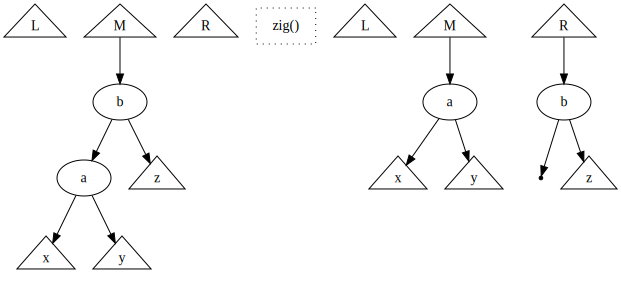

In [5]:
x1 = Node("x", None, None); y1 = Node("y", None, None); z1 = Node("z", None, None)
a1 = Node("a", x1, y1); b1 = Node("b", a1, z1)
l1 = UnaryTree("L", None); m1 = UnaryTree("M", b1); r1 = UnaryTree("R", None)

x2 = Node("x", None, None); y2 = Node("y", None, None); z2 = Node("z", None, None)
a2 = Node("a", x2, y2); b2 = Node("b", None, z2)
l2 = UnaryTree("L", None); m2 = UnaryTree("M", a2); r2 = UnaryTree("R", b2)

dot = l1.graph([m1, r1, Method("zig()"), l2, m2, r2])
for subtree in x1, y1, z1, x2, y2, z2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir bewegen den Knoten $a$ an die Wurzel, wobei $b$ gemeinsam mit seinem rechten Teilbaum $z$ links unten an $R$ angefügt wird. Die Ordnung bleibt erhalten, da $b > a$ ist, und da alle Elemente, die zuvor schon in $R$ waren, auch größer als $b$ sind.

Formal definieren wir $\text{zig}()$ unter der Angabe der momentanen Extrema in $L, R$ als Parameter als

$$\text{Node}(b, \text{Node}(a, x, y), z).\text{zig}(\text{max_}L, \text{min_}R) = \text{new_min_}R := \text{Node}(b, \text{Nil}, z); \text{min_}R.\text{left} := \text{new_min_}R; (\text{min_}L, \text{Node}(a, x, y), \text{new_min_}R)$$

wobei wir ein Tripel aus dem ungeänderten Maximum in $L$, aus der neuen Mitte und dem neuen Minimum in $R$ zurückgeben. Diese unveränderte Rückgabe erleichtert später die Definition des Splays als ganzen.

In Code definieren wir:

In [6]:
def _zig(self, max_less, min_greater):
    min_greater.left = self
    min_greater = self
    self = self.left
    min_greater.left = None
    return self, max_less, min_greater

Node._zig = _zig
del _zig

Um das vergleichsweise teure Konstruieren neuer Objekte zu vermeiden, schreiben wir lediglich die Referenzen um. Weniger geschrieben würde auch, wenn wir, statt lokale Variablen zu überschreiben, die neuen Werte direkt zurückgeben würden. Wir werden aber später die Schritte ohnehin in eine Methode schreiben, sodass dies nur die Lesbarkeit behindern würde.

Ähnlich definieren wir *Zag*, bei dem der zu splayende Knoten das rechte Kind der Wurzel ist. Hier modifizieren wir das Maximum in $L$.

$$\text{Node}(b, x, \text{Node}(a, y, z)).\text{zag}(\text{max_}L, \text{min_}R) = \text{new_max_}L := \text{Node}(b, x, \text{Nil}); \text{max_L}.\text{right} := \text{new_max_}L; (\text{new_max_}L, \text{Node}(a, y, z), \text{min_}R)$$

In [7]:
def _zag(self, max_less, min_greater):
    max_less.right = self
    max_less = self
    self = self.right
    max_less.right = None
    return max_less, self, min_greater

Node._zag = _zag
del _zag

### Zig-Zig und Zag-Zag

Als nächstes behandeln wir den Fall, dass der Knoten wenigstens zwei Ebenen von der Wurzel entfernt ist, und sowohl der Knoten als auch sein Elternknoten ein linkes Kind sind. Die Operation, die auf diese Ausgangssituation anzuwenden ist, bezeichnen wir als *Zig-Zig*. Diese Operation sieht so aus:

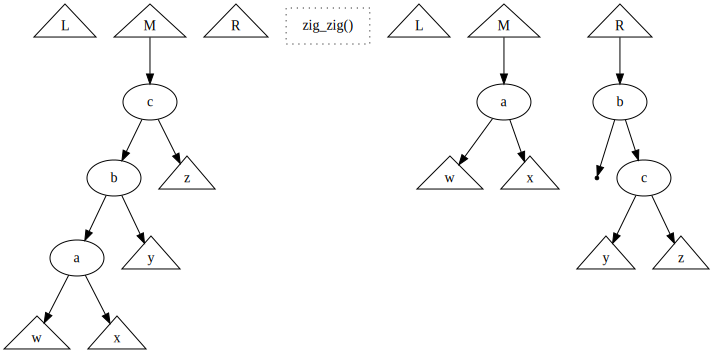

In [8]:
w1 = Node("w", None, None); x1 = Node("x", None, None); y1 = Node("y", None, None); z1 = Node("z", None, None)
a1 = Node("a", w1, x1); b1 = Node("b", a1, y1); c1 = Node("c", b1, z1)
l1 = UnaryTree("L", None); m1 = UnaryTree("M", c1); r1 = UnaryTree("R", None)

w2 = Node("w", None, None); x2 = Node("x", None, None); y2 = Node("y", None, None); z2 = Node("z", None, None)
a2 = Node("a", w2, x2); c2 = Node("c", y2, z2); b2 = Node("b", None, c2)
l2 = UnaryTree("L", None); m2 = UnaryTree("M", a2); r2 = UnaryTree("R", b2)

dot = l1.graph([m1, r1, Method("zig_zig()"), l2, m2, r2])
for subtree in w1, x1, y1, z1, w2, x2, y2, z2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir bewegen den Knoten $a$ an die Wurzel. $b$ wird mit $c$ als rechtes Kind an $R$ angefügt, wobei $c$ als seinen linken Teilbaum $y$ hat. Die Ordnungsbedingung bleibt erhalten, da $c > b > a$ und $y > c > b$ ist.

Wir definieren unter Angabe der Extrema

$$\text{Node}(c, \text{Node}(b, \text{Node}(a, w, x), y), z).\text{zig_zig}(\text{max_}L, \text{min_}R) = \text{new_min_}R := \text{Node}(b, \text{Nil}, \text{Node}(c, y, z)); \text{min_}R.\text{left} := \text{new_min_}R; (\text{max_}L, \text{Node}(a, w, x), \text{new_min_}R$$

und in Code

In [9]:
def _zig_zig(self, max_less, min_greater):
    tmp = self.left
    self.left = tmp.right
    tmp.right = self
    min_greater.left = tmp
    min_greater = tmp
    self = tmp.left
    min_greater.left = None
    return max_less, self, min_greater

Node._zig_zig = _zig_zig
del _zig_zig

Wir bezeichnen die gleiche Situation mit rechtem Kind und rechtem Enkel als *Zag-Zag*. Der Splay-Schritt ist ähnlich definiert.

$$\text{Node}(c, w, \text{Node}(b, x, \text{Node}(a, y, z))).\text{zag_zag}(\text{max_}L, \text{min_}R) = \text{new_max_}L := \text{Node}(b, \text{Node}(c, w, x), \text{Nil}); \text{max_}L.\text{right} := \text{new_max_}L; (\text{new_max_}L, \text{Node}(a, y, z), \text{min_}R)$$

In [10]:
def _zag_zag(self, max_less, min_greater):
    tmp = self.right
    self.right = tmp.left
    tmp.left = self
    max_less.right = tmp
    max_less = tmp
    self = tmp.right
    max_less.right = None
    return max_less, self, min_greater

Node._zag_zag = _zag_zag
del _zag_zag

### Zig-Zag und Zag-Zig

Zuletzt behandeln wir den Fall, dass der Elternknoten ein linkes Kind, der Knoten selbst aber ein rechtes Kind ist. Die Operation auf diese Situation nennen wir *Zig-Zag*. Für diese Operation brauchen wir erstmalig sowohl $L$ als auch $R$:

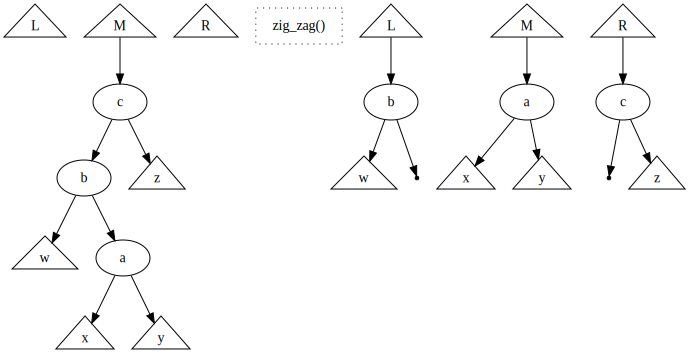

In [11]:
w1 = Node("w", None, None); x1 = Node("x", None, None); y1 = Node("y", None, None); z1 = Node("z", None, None)
a1 = Node("a", x1, y1); b1 = Node("b", w1, a1); c1 = Node("c", b1, z1)
l1 = UnaryTree("L", None); m1 = UnaryTree("M", c1); r1 = UnaryTree("R", None)

w2 = Node("w", None, None); x2 = Node("x", None, None); y2 = Node("y", None, None); z2 = Node("z", None, None)
a2 = Node("a", x2, y2); b2 = Node("b", w2, None); c2 = Node("c", None, z2)
l2 = UnaryTree("L", b2); m2 = UnaryTree("M", a2); r2 = UnaryTree("R", c2)

dot = l1.graph([m1, r1, Method("zig_zag()"), l2, m2, r2])
for subtree in w1, x1, y1, z1, w2, x2, y2, z2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir bewegen den Knoten $a$ an die Stelle von $c$, dabei werden $b$ und $c$ respektive an $L$ und $R$ angefügt, die ja jeweils kleiner bzw. größer als $a$ sind.

Wir definieren, diesmal unter Angabe beider Extrema

$$\text{Node}(c, \text{Node}(b, w, \text{Node}(a, x, y)), z).\text{zig_zag}(\text{max_}L, \text{min_}R) = \text{new_max_}L := \text{Node}(b, w, \text{Nil}); \text{max_}L.\text{right} := \text{new_max_}L;$$
$$\text{new_min_}R := \text{Node}(c, \text{Nil}, z); \text{max_}R.\text{left} := \text{new_max_}R; (\text{new_max_}L, \text{Node}(a, x, y), \text{new_min_}R)$$

und erhalten auch beide neuen Extrema zurück.

In Code haben wir

In [12]:
def _zig_zag(self, max_less, min_greater):
    max_less.right = self.left
    max_less = self.left
    min_greater.left = self
    min_greater = self
    self = self.left.right
    max_less.right = None
    min_greater.left = None
    return max_less, self, min_greater

Node._zig_zag = _zig_zag
del _zig_zag

In umgekehrter Reihenfolge, d.h. der Elternknoten ist das rechte Kind, der Knoten das linke Kind, haben wir die Operation *Zag-Zig* mit

$$\text{Node}(c, w, \text{Node}(b, \text{Node}(a, x, y), z)).\text{zag_zig}(\text{max_}L, \text{min_}R) = \text{new_max_}L := \text{Node}(c, w, \text{Nil}); \text{max_}L.\text{right} := \text{new_max_}L;$$
$$\text{new_min_}R := \text{Node}(b, \text{Nil}, z); \text{min_}R.\text{left} := \text{new_min_}R; \text{Node}(a, x, y); (\text{new_max_}L, \text{Node}(a, x, y), \text{new_min_}R$$

In [13]:
def _zag_zig(self, max_less, min_greater):
    max_less.right = self
    max_less = self
    min_greater.left = self.right
    min_greater = self.right
    self = self.right.left
    max_less.right = None
    min_greater.left = None
    return max_less, self, min_greater

Node._zag_zig = _zag_zig
del _zag_zig

### Vergleich beliebiger Nutzlasten

Wir müssen, um später Mengen, die Elemente unterschiedlicher Typen enthalten, zu unterstützen, dazu in der Lage sein, beliebige Nutzlasten zu vergleichen. Dazu vergleichen wir zuerst den Klassennamen und, falls dieser gleich ist, die Identität. Für Gleichheit erlauben wir beliebig viele Operanden, jedoch mindestens zwei.

In [14]:
def _arb_gt(self, x, y):
    if type(x).__name__ == type(y).__name__:
        return x > y
    return type(x).__name__ > type(y).__name__

def _arb_lt(self, x, y):
    if type(x).__name__ == type(y).__name__:
        return x < y
    return type(x).__name__ < type(y).__name__

def _arb_eq(self, x, y, *args):
    for operand in [y, *args]:
        if type(x).__name__ != type(operand).__name__ or x is not operand:
            return False
    return True

Node._arb_gt = _arb_gt
Node._arb_lt = _arb_lt
Node._arb_eq = _arb_eq
del _arb_gt, _arb_lt, _arb_eq

### Verkettung der Schritte

Das *Splayen* eines Knotens, also das Bewegen an die Wurzel, funktioniert durch das wiederholte Durchführen der Zig-, Zig-Zig- und Zig-Zag-Schritte (und umgekehrt), bis alle Elternknoten dieses Knotens beiseite gelegt sind.

Falls der gesuchte Knoten noch genau eine Ebene entfernt ist, so führen wir Zig bzw. Zag durch. In diesem Fall unterscheiden wir:

|Linkes Kind|Rechtes Kind|
|-----------|------------|
|Zig        |Zag         |

Falls er noch mindestens zwei Ebenen entfernt ist, so unterscheiden wir:

|                 |Linkes Kind|Rechtes Kind|
|-----------------|-----------|------------|
|**Linker Enkel** |Zig-Zig    |Zig-Zag     |
|**Rechter Enkel**|Zag-Zig    |Zag-Zag     |

oder formaler, wobei wir den gesuchten Knoten als $\text{sought}$ bezeichnen:

- $M = \text{Node}(v, \text{Node}(w, x, y), z) \land \text{sought} = w \Rightarrow M.\text{splay_step}() = M.\text{zig}(\text{max_}L, \text{min_}R)$
- $M = \text{Node}(v, w, \text{Node}(x, y, z)) \land \text{sought} = x \Rightarrow M.\text{splay_step}() = M.\text{zag}(\text{max_}L, \text{min_}R)$
- $M = \text{Node}(v, \text{Node}(w, x, y), z) \land \text{sought} < w \Rightarrow M.\text{splay_step}() = M.\text{zig_zig}(\text{max_}L, \text{min_}R)$
- $M = \text{Node}(v, w, \text{Node}(x, y, z)) \land \text{sought} > x \Rightarrow M.\text{splay_step}() = M.\text{zag_zag}(\text{max_}L, \text{min_}R)$
- $M = \text{Node}(v, \text{Node}(w, x, y), z) \land \text{sought} > w \Rightarrow M.\text{splay_step}() = M.\text{zig_zag}(\text{max_}L, \text{min_}R)$
- $M = \text{Node}(v, w, \text{Node}(x, y, z)) \land \text{sought} < x \Rightarrow M.\text{splay_step}() = M.\text{zag_zig}(\text{max_}L, \text{min_}R)$

Die Schritte werden wiederholt, bis an der Wurzel festgestellt werden kann, ob der gesuchte Knoten vorhanden ist. In diesem Fall fügen wir noch die Teilbäume von der neuen Wurzel an $L, R$ an und setzen $L, R$ als Teilbäume dieser neuen Wurzel.

- $M = \text{Node}(x, y, z) \land \lnot(\text{sought} = x \lor (x < \text{sought} \land y = \text{Nil}) \lor (x > \text{sought} \land z = \text{Nil})) \Rightarrow M.\text{splay}() = \text{max_}L, M, \text{min_}R := M.\text{splay_step}()$
- $M = \text{Node}(x, y, z) \land (\text{sought} = x \lor (x < \text{sought} \land y = \text{Nil}) \lor (x > \text{sought} \land z = \text{Nil})) \Rightarrow M.\text{splay}() = \text{max_}L.\text{right} := y; \text{min_}R.\text{left} := z; \text{Node}(x, L, R)$

Die Implementierung halten wir *iterativ*, um Funktionsaufrufe und Grenzen von Rekursionstiefe zu vermeiden:

In [15]:
def _splay(self, payload):
    max_less = min_greater = set_aside = Node(None, None, None)
    while True:
        if self._arb_lt(payload, self.payload):
            if self.left is None:
                break
            if self._arb_lt(payload, self.left.payload) and self.left.left is not None:
                max_less, self, min_greater = self._zig_zig(max_less, min_greater)
                continue
            if self._arb_gt(payload, self.left.payload) and self.left.right is not None:
                max_less, self, min_greater = self._zig_zag(max_less, min_greater)
                continue
            max_less, self, min_greater = self._zig(max_less, min_greater)
            break
        if self._arb_gt(payload, self.payload):
            if self.right is None:
                break
            if self._arb_gt(payload, self.right.payload) and self.right.right is not None:
                max_less, self, min_greater = self._zag_zag(max_less, min_greater)
                continue
            if self._arb_lt(payload, self.right.payload) and self.right.left is not None:
                max_less, self, min_greater = self._zag_zig(max_less, min_greater)
                continue
            max_less, self, min_greater = self._zag(max_less, min_greater)
            break
        break
    max_less.right = self.left
    min_greater.left = self.right
    self.left = set_aside.right
    self.right = set_aside.left
    return self

Node._splay = _splay
del _splay

Das nächste Beispiel zeigt, wie ein Splay aus einem schlechtestmöglich balancierten Baum einen deutlich besser balancierten Baum machen kann:

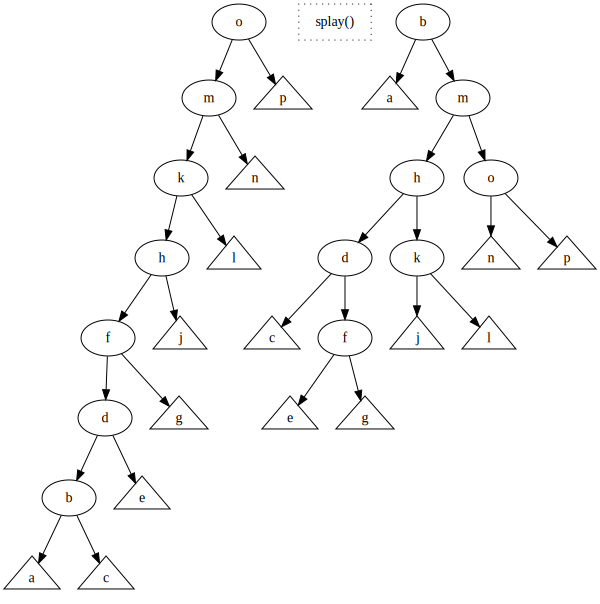

In [16]:
a1 = Node("a", None, None); c1 = Node("c", None, None); e1 = Node("e", None, None); g1 = Node("g", None, None)
j1 = Node("j", None, None); l1 = Node("l", None, None); n1 = Node("n", None, None); p1 = Node("p", None, None)
b1 = Node("b", a1, c1); d1 = Node("d", b1, e1); f1 = Node("f", d1, g1); h1 = Node("h", f1, j1)
k1 = Node("k", h1, l1); m1 = Node("m", k1, n1); o1 = Node("o", m1, p1)

a2 = Node("a", None, None); c2 = Node("c", None, None); e2 = Node("e", None, None); g2 = Node("g", None, None)
j2 = Node("j", None, None); l2 = Node("l", None, None); n2 = Node("n", None, None); p2 = Node("p", None, None)
b2 = Node("b", a2, c2); d2 = Node("d", b2, e2); f2 = Node("f", d2, g2); h2 = Node("h", f2, j2)
k2 = Node("k", h2, l2); m2 = Node("m", k2, n2); o2 = Node("o", m2, p2)

dot = o1.graph([Method("splay()"), o2._splay("b")])
for subtree in a1, c1, e1, g1, j1, l1, n1, p1, a2, c2, e2, g2, j2, l2, n2, p2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Ein anderes Beispiel enthält alle Schritte außer Zag:

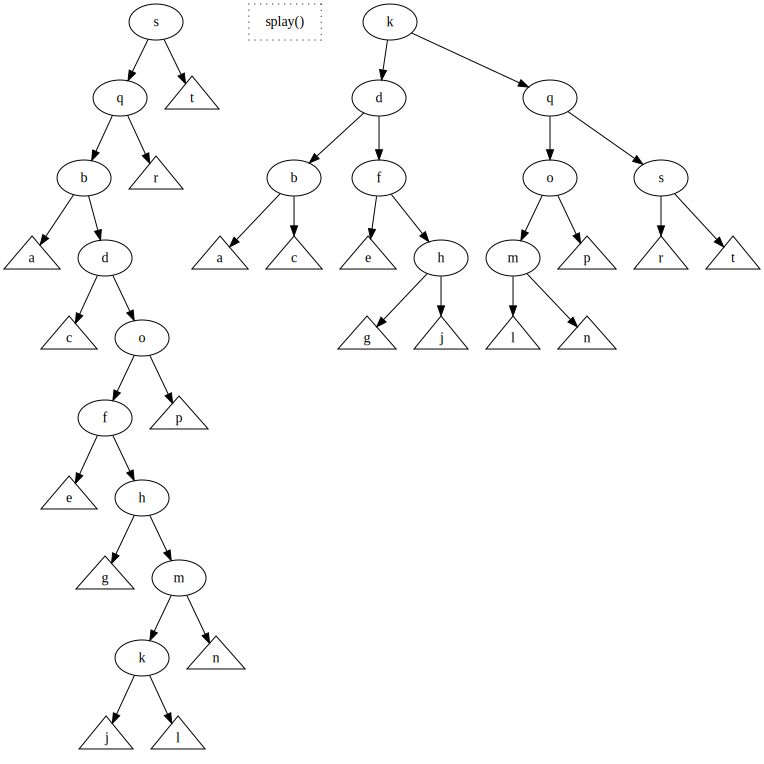

In [17]:
j1 = Node("j", None, None); l1 = Node("l", None, None); n1 = Node("n", None, None); g1 = Node("g", None, None)
e1 = Node("e", None, None); p1 = Node("p", None, None); c1 = Node("c", None, None); a1 = Node("a", None, None)
r1 = Node("r", None, None); t1 = Node("t", None, None)
k1 = Node("k", j1, l1); m1 = Node("m", k1, n1); h1 = Node("h", g1, m1); f1 = Node("f", e1, h1)
o1 = Node("o", f1, p1); d1 = Node("d", c1, o1); b1 = Node("b", a1, d1); q1 = Node("q", b1, r1)
s1 = Node("s", q1, t1)

j2 = Node("j", None, None); l2 = Node("l", None, None); n2 = Node("n", None, None); g2 = Node("g", None, None)
e2 = Node("e", None, None); p2 = Node("p", None, None); c2 = Node("c", None, None); a2 = Node("a", None, None)
r2 = Node("r", None, None); t2 = Node("t", None, None)
k2 = Node("k", j2, l2); m2 = Node("m", k2, n2); h2 = Node("h", g2, m2); f2 = Node("f", e2, h2)
o2 = Node("o", f2, p2); d2 = Node("d", c2, o2); b2 = Node("b", a2, d2); q2 = Node("q", b2, r2)
s2 = Node("s", q2, t2)

dot = s1.graph([Method("splay()"), s2._splay("k")])
for subtree in a1, c1, e1, g1, j1, l1, n1, p1, r1, t1, a2, c2, e2, g2, j2, l2, n2, p2, r2, t2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir betrachten zuletzt das folgende Beispiel, um Zag abgedeckt zu haben:

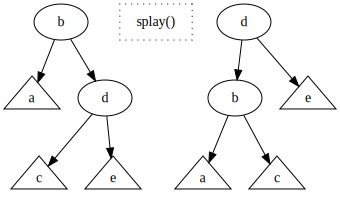

In [18]:
a1 = Node("a", None, None); c1 = Node("c", None, None); e1 = Node("e", None, None)
d1 = Node("d", c1, e1); b1 = Node("b", a1, d1)

a2 = Node("a", None, None); c2 = Node("c", None, None); e2 = Node("e", None, None)
d2 = Node("d", c2, e2); b2 = Node("b", a2, d2)

dot = b1.graph([Method("splay()"), b2._splay("d")])
for subtree in a1, c1, e1, a2, c2, e2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Schließlich definieren wir `_splay()` so, dass die Routinen für die einzelnen Schritte nicht in eigenen Methoden aufgerufen werden, um Aufrufe zu sparen. Wir überschreiben auch nicht die inneren Teilbäume der neuen Extrema mit `None`, da diese sowieso in jedem Schritt sowie am Ende überschrieben werden.

In [19]:
def _splay(self, payload):
    max_less = min_greater = set_aside = Node(None, None, None)
    while True:
        if self._arb_lt(payload, self.payload):
            if self.left is None:
                break
            if self._arb_lt(payload, self.left.payload) and self.left.left is not None:
                tmp = self.left
                self.left = tmp.right
                tmp.right = self
                min_greater.left = tmp
                min_greater = tmp
                self = tmp.left
                continue
            if self._arb_gt(payload, self.left.payload) and self.left.right is not None:
                max_less.right = self.left
                max_less = self.left
                min_greater.left = self
                min_greater = self
                self = self.left.right
                continue
            min_greater.left = self
            min_greater = self
            self = self.left
            break
        if self._arb_gt(payload, self.payload):
            if self.right is None:
                break
            if self._arb_gt(payload, self.right.payload) and self.right.right is not None:
                tmp = self.right
                self.right = tmp.left
                tmp.left = self
                max_less.right = tmp
                max_less = tmp
                self = tmp.right
                continue
            if self._arb_lt(payload, self.right.payload) and self.right.left is not None:
                max_less.right = self
                max_less = self
                min_greater.left = self.right
                min_greater = self.right
                self = self.right.left
                continue
            max_less.right = self
            max_less = self
            self = self.right
            break
        break
    max_less.right = self.left
    min_greater.left = self.right
    self.left = set_aside.right
    self.right = set_aside.left
    return self

Node._splay = _splay
del _splay

## Standardoperationen

Wir definieren für den Splay Tree als nächstes die grundlegenden Operationen auf Bäume: Einfügen, Löschen, auf das Vorhandensein eines Elements überprüfen, und auf das Leersein überprüfen.

### Einfügen

Beim Einfügen traversieren wir nicht, wie bei den meisten Bäumen und auch bei der Verwendung des Bottom-Up-Splaying-Ansatzes, den Baum hinunter, sondern splayen an dem Element, das wir einfügen wollen. Offenbar ist die Wurzel des gesplayten Baums dann entweder schon das einzufügende Element; in diesem Fall sind wir fertig. Wir bezeichnen den Baum mit $B$ und das neue Element mit $k$. Ist der Baum noch leer, so brauchen wir nur die Wurzel setzen:

$$B = \text{Nil} \Rightarrow B.\text{insert}(k) = \text{Node}(k, \text{Nil}, \text{Nil})$$
$$B.\text{splay}(k) = \text{Node}(k, x, y) \Rightarrow B.\text{insert}(k) = B.\text{splay}(k)$$

Andernfalls ist die neue Wurzel genau das Element, das im ganzen Baum das nächstgrößere oder nächstkleinere als das einzufügende Element ist, oder formaler:

$$B.\text{splay}(k) = \text{Node}(x, y, z) \Rightarrow x = k \lor x = \max(\{\kappa \in B: \kappa < k\}) \lor x = \min(\{\kappa \in B: \kappa > k\})$$

Warum ist das notwendigerweise der Fall? Wir fassen die Elemente im Baum sowie das einzufügende Element $k$ als totale Ordnung auf, wobei das Ordnungskriterium im Folgenden die alphabetische Reihenfolge der Variablennamen ist ($a < b$, $b < c$ etc.) Wir notieren diese Elemente als sortierte Liste:

$$[a, b, c, \dots, j, k, l, \dots, x, y, z]$$

Dann ist also $\{\kappa \in B: \kappa < k\} = [a, \dots, j]$ und $\{\kappa \in B: \kappa > k\} = [l, \dots, z]$.

Wenn wir nun beim Splayen einen Knoten an $L$ anhängen, so ist dieser, wie auch sein linker Teilbaum, in $\{\kappa \in B: \kappa < k\}$. Bezeichnen wir diesen Knoten als $b$ und diesen linken Teilbaum als $a$, so betrachten wir im nächsten Schritt nur noch

$$[c, \dots, j, l, \dots, x, y, z]$$

und haben unter den betrachteten Elementen $B'$ die Menge $\{\kappa \in B': \kappa < k\}$ **verkleinert**, wobei alle entnommenen Elemente **kleiner** als die übrigen Elemente sind. Analog verkleinern wir die Menge $\{\kappa \in B': \kappa > k\}$, wobei alle entnommenen Elemente **größer** als die übrigen Elemente sind, wenn wir einen Knoten an $R$ anhängen, z.B. $y$ mit $z$ als rechtem Teilbaum, sodass nurmehr

$$[a, b, c, \dots, j, l, \dots, x]$$

übrig bleiben. Da wir anhand von $k$ eingrenzen, bleibt am Ende gerade $j = \max(\{\kappa \in B: \kappa < k\})$ oder $l = \min(\{\kappa \in B: \kappa > k\})$ übrig, und eines dieser Elemente werden wir an die Wurzel gesplayt haben.

In diesen beiden Fällen setzen wir das einzufügende Element $k$ als Wurzel. Im Fall, dass $k$ kleiner als die Wurzel des gesplayten existierenden Baums $B' = \text{Node}(x, y, z)$ ist, sind trotzdem alle Elemente im linken Teilbaum $y$ von $B'$ kleiner als $k$ und wir setzen diesen als linken Teilbaum von $k$. Wir setzen die Wurzel $x$ von $B'$ als rechten Teilbaum, da sie, wie auch alle Elemente des rechten Teilbaums $z$ von $B'$ größer als $k$ sind. Dabei setzen wir den linken Teilbaum von $x$ auf $\text{Nil}$.

$$B.\text{splay}(k) = \text{Node}(x, y, z) \land k < x \Rightarrow B.\text{insert}(k) = \text{Node}(k, y, \text{Node}(x, \text{Nil}, z))$$

oder graphisch:

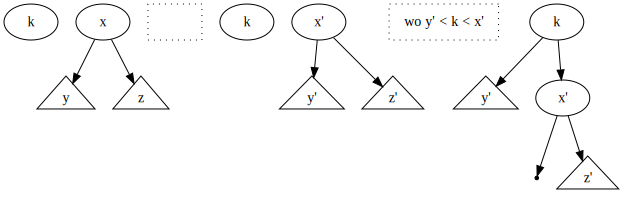

In [20]:
y1 = Node("y", None, None); z1 = Node("z", None, None); x1 = Node("x", y1, z1); k1 = Node("k", None, None)
y2 = Node("y'", None, None); z2 = Node("z'", None, None); x2 = Node("x'", y2, z2); k2 = Node("k", None, None)
y3 = Node("y'", None, None); z3 = Node("z'", None, None); x3 = Node("x'", None, z3); k3 = Node("k", y3, x3)

dot = k1.graph([x1, Method(""), k2, x2, Method("wo y' < k < x'"), k3])
for subtree in y1, z1, y2, z2, y3, z3:
    dot.node(str(id(subtree)), shape="triangle")
dot

Im Fall, dass $k$ größer als die Wurzel $x$ des gesplayten Baums $B' = \text{Node}(x, y, z)$ ist, sind umgekehrt alle Elemente in dessen rechten Teilbaum $z$ größer als $k$, und wir setzen die Wurzel dieses Baumes $x$ als linken Teilbaum des neuen Elements $k$, wobei dieser Knoten dann als linken Teilbaum $y$ hat, als rechten Teilbaum $\text{Nil}$.

$$B.\text{splay}(k) = \text{Node}(x, y, z) \land k > x \Rightarrow B.\text{insert}(k) = \text{Node}(k, \text{Node}(x, y, \text{Nil}), z)$$

und graphisch:

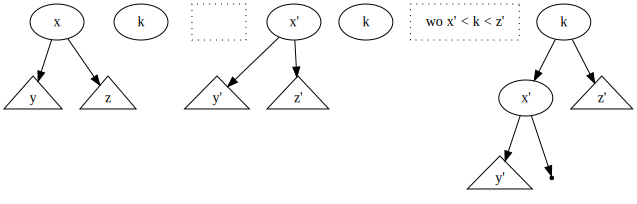

In [21]:
y1 = Node("y", None, None); z1 = Node("z", None, None); x1 = Node("x", y1, z1); k1 = Node("k", None, None)
y2 = Node("y'", None, None); z2 = Node("z'", None, None); x2 = Node("x'", y2, z2); k2 = Node("k", None, None)
y3 = Node("y'", None, None); z3 = Node("z'", None, None); x3 = Node("x'", y3, None); k3 = Node("k", x3, z3)

dot = x1.graph([k1, Method(""), x2, k2, Method("wo x' < k < z'"), k3])
for subtree in y1, z1, y2, z2, y3, z3:
    dot.node(str(id(subtree)), shape="triangle")
dot

In [22]:
def insert(self, payload):
    self = self._splay(payload)
    if self._arb_eq(payload, self.payload):
        return self
    if self._arb_lt(payload, self.payload):
        tmp = self.left
        self.left = None
        return Node(payload, tmp, self)
    tmp = self.right
    self.right = None
    return Node(payload, self, tmp)

Node.insert = insert
del insert

Für den leeren Baum brauchen wir nur das Element in einen neuen Knoten setzen. Wir definieren – unter anderem zur Betrachtung des Falls des leeren Baumes – die Klasse `SplayTree`, die das Management des leeren Baums wie auch der Tatsache, dass sich bei einem Splay die Wurzel ändert, nach außen vereinfacht.

In [23]:
class SplayTree:
    def __init__(self):
        self.tree = None
    
    def graph(self):
        if self.tree is None:
            return Digraph()
        return self.tree.graph()
    
    def insert(self, payload):
        if self.tree is None:
            self.tree = Node(payload, None, None)
        else:
            self.tree = self.tree.insert(payload)

Einige Beispiele zeigen das Einsetzen von Knoten in Splay Trees:

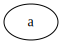

In [24]:
my_splay = SplayTree()
my_splay.insert("a")
my_splay.graph()

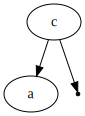

In [25]:
my_splay.insert("c")
my_splay.graph()

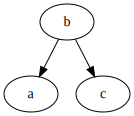

In [26]:
my_splay.insert("b")
my_splay.graph()

### Entfernen

Wir definieren als nächstes das Entfernen eines Elementes. Wir splayen wieder am zu entfernenden Element und haben dann einen Baum, der das zu entfernende Element als Wurzel hat. Sollte sich nach dem Splayen herausstellen, dass das Element nicht vorhanden ist, werfen wir einen `KeyError`, [da sich so auch die Mengen in Python verhalten](https://docs.python.org/3.8/library/stdtypes.html#set "Python Software Foundation (2019): The Python Standard Library/Built-in Types/set, Python Documentation"). In der Definition schreiben wir $\downarrow$ für das Undefinierte. Dies tritt auch ein, wenn der Baum leer ist:

$$B = \text{Nil} \Rightarrow B.\text{remove}(k)\downarrow$$
$$B.\text{splay}(k) \neq \text{Node}(k, x, y) \Rightarrow B.\text{remove}(k)\downarrow$$

Andernfalls überprüfen wir, ob ein Teilbaum des gesplayten Baums leer ist. In diesem Fall ist der neue Baum einfach der andere Teilbaum.

$$B.\text{splay}(k) = \text{Node}(k, \text{Nil}, x) \Rightarrow B.\text{remove}(k) = x$$
$$B.\text{splay}(k) = \text{Node}(k, x, \text{Nil}) \Rightarrow B.\text{remove}(k) = x$$

Ist das nicht der Fall, so sorgen wir dafür, dass der linke Teilbaum des gesplayten Baums keinen rechten Teilbaum mehr hat, sodass wir den rechten Teilbaum des gesplayten Baums anfügen können. Eine Grafik illustriert, was gemeint ist:

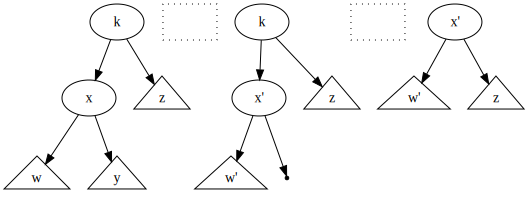

In [27]:
w1 = Node("w", None, None); y1 = Node("y", None, None); z1 = Node("z", None, None); x1 = Node("x", w1, y1); k1 = Node("k", x1, z1)
w2 = Node("w'", None, None); z2 = Node("z", None, None); x2 = Node("x'", w2, None); k2 = Node("k", x2, z2)
w3 = Node("w'", None, None); z3 = Node("z", None, None); x3 = Node("x'", w3, z3)

dot = k1.graph([Method(""), k2, Method(""), x3])
for subtree in w1, y1, z1, w2, z2, w3, z3:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir machen aus dem Baum $\text{Node}(x, w, y)$ den Baum $\text{Node}(x', w', \text{Nil})$, indem wir an $k$ splayen. Da das Maximum aus $\text{Node}(x, w, y)$ kleiner $k$ ist, muss dann gerade dieses Maximum die Wurzel ($x'$) werden und kann keinen rechten Teilbaum mehr haben.

$$B.\text{splay}(k) = \text{Node}(k, \text{Node}(x, w, y), z) \land \text{Node}(x, w, y).\text{splay}(k) = \text{Node}(x', w', \text{Nil}) \Rightarrow B.\text{remove}(k) = \text{Node}(x', w', z)$$

Wir werfen in der Implementierung erst auf Ebene von `SplayTree` den `KeyError`, um im Baum noch aufräumen zu können. Der Nutzer könnte ja im Falle eines `KeyError`s diesen auffangen wollen und die Menge trotzdem noch benutzen wollen.

In [28]:
def remove(self, payload):
    self = self._splay(payload)
    if not self._arb_eq(payload, self.payload):
        return False, self
    if self.left is None:
        return True, self.right
    if self.right is None:
        return True, self.left
    tmp = self.right
    self = self.left._splay(payload)
    self.right = tmp
    return True, self

Node.remove = remove
del remove

def remove(self, payload):
    if self.tree is None:
        raise KeyError(payload)
    rc, self.tree = self.tree.remove(payload)
    if not rc:
        raise KeyError(payload)

SplayTree.remove = remove
del remove

Einige Beispiele zeigen das Entfernen von Elementen.

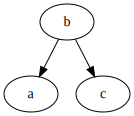

In [29]:
my_splay = SplayTree()
for letter in ["a", "c", "b"]:
    my_splay.insert(letter)
my_splay.graph()

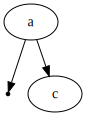

In [30]:
my_splay.remove("b")
my_splay.graph()

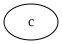

In [31]:
my_splay.remove("a")
my_splay.graph()

### Finden

Wir definieren als nächstes das Überprüfen eines Baumes auf ein Element. In unserer Definition wird ein Tupel aus dem Vorhandensein und der neuen Wurzel zurückgegeben.

Wir splayen am gesuchten Element und können schon an der Wurzel erkennen, ob das Element vorhanden ist. Noch einfacher haben wir es, wenn keine Elemente im Baum sind:

$$B = \text{Nil} \Rightarrow B.\text{contains}(k) = (\text{false}, \text{Nil})$$
$$B.\text{splay}(k) = \text{Node}(k, y, z) \Rightarrow B.\text{contains}(k) = (\text{true}, \text{Node}(k, y, z))$$
$$B.\text{splay}(k) = \text{Node}(x, y, z) \land k \neq x \Rightarrow B.\text{contains}(k) = (\text{false}, \text{Node}(x, y, z))$$

In [32]:
def contains(self, payload):
    self = self._splay(payload)
    return self._arb_eq(payload, self.payload), self

Node.contains = contains
del contains

def contains(self, payload):
    if self.tree is None:
        return False
    contains, self.tree = self.tree.contains(payload)
    return contains

SplayTree.contains = contains
del contains

Beispiele zeigen uns:

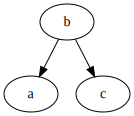

In [33]:
my_splay = SplayTree()
for letter in ["a", "c", "b"]:
    my_splay.insert(letter)
my_splay.graph()

In [34]:
my_splay.contains("a")

True

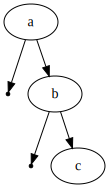

In [35]:
my_splay.graph()

In [36]:
my_splay.contains("d")

False

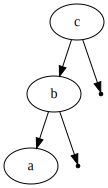

In [37]:
my_splay.graph()

### Leerüberprüfung

Wir definieren zuletzt, wie wir überprüfen, ob der Baum leer ist.

$$\text{Node} = \text{Nil} \Rightarrow \text{Node}.\text{is_empty}() = \text{true}$$
$$\text{Node} \neq \text{Nil} \Rightarrow \text{Node}.\text{is_empty}() = \text{false}$$

Die Implementierung findet von `SplayTree` aus statt.

In [38]:
def is_empty(self):
    return self.tree is None

SplayTree.is_empty = is_empty
del is_empty

In [39]:
my_splay = SplayTree()
my_splay.is_empty()

True

In [40]:
my_splay.insert("a")
my_splay.is_empty()

False

## Anwendungsbeispiel: Sieb des Eratosthenes

Als Anwendungsbeispiel benutzen wir den `SplayTree` als Menge, um alle Primzahlen bis zu einem Maximum abzulegen. Die Primzahlen werden dabei mit dem Sieb des Eratosthenes berechnet. Die Implementierung ist sehr einfach gehalten und hat Raum für Optimierungen, aber das ist für den Vergleich mit `set` unproblematisch.

In [41]:
def splay_primes(n):
    primes = SplayTree()
    for i in range(2, n + 1):
        primes.insert(i)
    for i in range(2, n + 1):
        for j in range(2 * i, n + 1, i):
            if primes.contains(j):
                primes.remove(j)
    return primes

Wir berechnen probeweise die Primzahlen bis 100. Vor dem Anzeigen splayen wir noch an einzelnen Knoten sowie am Median der Primzahlen bis 100, 41. Nach dem Sieb des Eratosthenes ist der Baum sehr unbalanciert, so wird die Anzeige etwas lesefreundlicher.

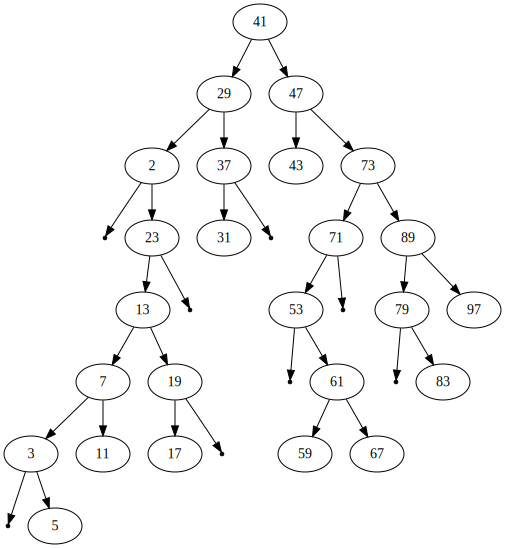

In [42]:
primes = splay_primes(100)
for i in range(0, 100, 25):
    primes.tree = primes.tree._splay(i)
primes.tree = primes.tree._splay(41)
primes.graph()

Wir wiederholen die Implementierung mit dem eingebauten `set`.

In [43]:
def set_primes(n):
    primes = set()
    for i in range(2, n + 1):
        primes.add(i)
    for i in range(2, n + 1):
        for j in range(2 * i, n + 1, i):
            primes -= set([j])
    return primes

In [44]:
print(set_primes(100))

{2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97}


Wir betrachten nun vergleichend die Ausführungszeiten beider Varianten.

In [45]:
splay_times = %timeit -o splay_primes(10**4)
splay_time = splay_times.best
set_times = %timeit -o set_primes(10**4)
set_time = set_times.best
if splay_time > set_time:
    print(f"Splaying was {round(splay_time / set_time, 2)} times slower")
else:
    print(f"Splaying was {round(set_time / splay_time, 2)} times faster")

1.14 s ± 54.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
27.6 ms ± 792 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Splaying was 40.84 times slower


Dabei ist zu beachten, dass wir zu diesem Zeitpunkt die Python-Implementierung mit einer C-Implementierung vergleichen.

## Mengen auf Basis von Splay Trees

Wir benutzen nun die Splay Trees, um Mengen (`set`) in Python mit Ordnung zu unterstützen.

Dazu bauen wir die hier gelisteten Methoden nach ([Permalink zur Datei, aus der dies generiert wird](https://github.com/python/cpython/blob/3.8/Objects/setobject.c "R. D. Hettinger et al. (2019): cpython/Objects/setobject.c, GitHub")):

In [46]:
help(set)

Help on class set in module builtins:

class set(object)
 |  set() -> new empty set object
 |  set(iterable) -> new set object
 |  
 |  Build an unordered collection of unique elements.
 |  
 |  Methods defined here:
 |  
 |  __and__(self, value, /)
 |      Return self&value.
 |  
 |  __contains__(...)
 |      x.__contains__(y) <==> y in x.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __iand__(self, value, /)
 |      Return self&=value.
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __ior__(self, value, /)
 |      Return self|=value.
 |  
 |  __isub__(self, value, /)
 |      Return self-=value.
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __ixor__(self, value, /)
 |      Re

### Konstruktion

Wir unterstützen den leeren Konstruktor. Wir arbeiten direkt mit `Node`s, wrappen also nicht noch zusätzlich einen `SplayTree`. Unsere Klasse `OrderedSet` erbt von `set`.

In [47]:
class OrderedSet(set):
    def __init__(self):
        self._tree = None

Wenn wir das Konstruieren eines Sets aus einem `iterable` unterstützen wollen, begegnen wir dem Problem der Implementierung von *Mengen von Mengen*.

Seien $M, N$ Mengen und $M \in N$. $N$ ist also eine Menge von Mengen. Wie stellen wir sicher, dass $N$ geordnet bleibt, wenn $M$ geändert wird? Wir könnten verlangen, dass in $N$ eine Menge, wann immer sie preisgegeben wird, neu einsortiert werden muss. Abgesehen vom damit verbundenen Berechnungsaufwand ist dies aber nicht praktikabel, da auf $M$ auch Referenzen gehalten werden können, die nicht von $N$ abhängig sind, und somit $M$ geändert werden könnte, ohne dass $N$ davon erfährt. (Die $N$-seitige Überwachung aller gehaltenen Mengen wäre noch unpraktischer als das erneute Einsortieren.)

Ein vergleichbares Problem ergibt sich übrigens auch bei den Hashtabellen in der Referenzimplementierung CPython. Hier kann keine Ordnungsbedingung verletzt werden, jedoch ist i. A. eine Menge nach Änderung nicht mehr unter ihrem vorigen Hash zu finden. Der Python-Standard gibt daher vor, dass es strenggenommen keine Mengen von Mengen gibt – [es gibt nur Mengen von unmodifizierbaren Mengen](https://docs.python.org/3.8/library/stdtypes.html#set "Python Software Foundation (2019): The Python Standard Library/Built-in Types/set, Python Documentation"), den `frozenset`s.

Auch diese wollen wir geordnet haben und werden sie parallel mitimplementieren.

In [48]:
class OrderedFrozenset(frozenset):
    pass
OrderedFrozenset.__init__ = OrderedSet.__init__

Wir werden immer wieder Mengen einfrieren wollen und haben dafür die als intern markierte Methode `_freeze`.

In [49]:
def _freeze(self, element):
    if isinstance(element, OrderedSet):
        frozen = OrderedFrozenset()
        frozen._tree = element._tree
        return frozen
    elif isinstance(element, set):
        return OrderedFrozenset(element)
    return element

OrderedSet._freeze = _freeze
OrderedFrozenset._freeze = _freeze
del _freeze

Konstruieren wir nun eine Menge aus einem `iterable`, so fügen wir die Elemente einzeln ein:

In [50]:
def __init__(self, iterable):
    self._tree = None
    iterator = iter(iterable)
    try:
        self._tree = Node(self._freeze(next(iterator)), None, None)
        while True:
            self._tree = self._tree.insert(self._freeze(next(iterator)))
    except StopIteration:
        pass

OrderedSet.__init__ = __init__
OrderedFrozenset.__init__ = __init__
del __init__

### Iteration

Bevor wir in Reihenfolge der `help`-Seite mit `__and__` fortfahren können, benötigen wir `__iter__`, um durch die Elemente in der Menge iterieren zu können.

Dies erreichen wir, indem wir den Baum wie bei einer *Inorder*-Ausgabe durchlaufen, wobei wir zur Ausgabe das Keyword `yield` benutzen. Die Implementierung ist iterativ und hält sich einen eigenen Stapel, da dieser in seiner Größe weniger begrenzt ist als der Aufrufstapel, der sich bei einer rekursiven Implementierung aufbauen würde. Für diesen Stapel benutzen wir [`deque`](https://docs.python.org/3.8/library/collections.html#collections.deque "Python Software Foundation (2019): The Python Standard Library/Data Types/collections/deque, Python Documentation") (double-ended queue) aus den `collections` der Standard Library, da sich diese für größere Stapel besser eignet als die Liste.

In [51]:
def __iter__(self):
    stack = deque()
    tree = self._tree
    while stack or tree is not None:
        if tree is not None:
            stack.append(tree)
            tree = tree.left
            continue
        tree = stack.pop()
        yield tree.payload
        tree = tree.right

OrderedSet.__iter__ = __iter__
OrderedFrozenset.__iter__ = __iter__
del __iter__